In [152]:
### Import packages ###
import time, sys, os
import h5py
import numpy as np
import astropy as ap
import scipy
import pandas
from matplotlib.pyplot import *

# Import packages to display SDSS optical image
from PIL import Image
import requests

# Import packages to open fits and calculate cosmology
from astropy.io import fits
from astropy.cosmology import WMAP9
import astropy.coordinates as coord
from astroquery.sdss import SDSS
from scipy.io import readsav

# Import prospector 
sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling
from prospect.models.templates import TemplateLibrary
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import prospect.io.read_results as reader

import corner

# Import MCMC package
import emcee

# Import my build functions
from build_model_funct import build_model
from build_obs_funct import build_obs
from FracSFH_ import FracSFH

import seaborn as sns
import os

### re-defining plotting defaults for matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})
rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})

rcParams.update({'axes.prop_cycle': cycler(color = sns.color_palette("tab10"))})
%matplotlib inline

In [153]:
def build_sps(zcontinuous=1, **extras):
    """ Build sps object using FracSFH basis
    """
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

In [154]:
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

AGN_data[0]

(1, 'R1', 233.13199, 57.88292, 0.58, 0.034, 0.79, 0.023, 1.3, 0.067, 2.3, 0.11, 2.6, 0.13, 3.3, 0.16, 3.6, 0.18, 4.0, 0.32, 6.0, 0.48, 3.5, 0.46, 3.71, 0.02, 2.93, 0.03, 30.0, 0.17, '', 162.0, 1.79, 1150.0, 23.3, 1240.0, 33.5, 970.0, 31.6, 390.0, 14.9, '', 168.0, 19.6, '', 60.9, 17.2, 'SED', '', 2.08, 9.82, 0.24, 0.19, 7.49, 0.07, -2.33, 0.23, '<', 8.5, 0.0, 6.74, 0.05, '', 6.55, 0.06, 1, 'Sloan', 'SDSS J153231.67+575258.4')

In [155]:
# result, obs, __ = reader.results_from(Galaxy_Path + '{}_mcmc.h5'.format(run_params['ID']), dangerous=False)

In [156]:
# fig, axes = subplots(nrows= 5, ncols = 1, sharex=True, sharey=False)

In [157]:
print(os.path.basename('/mnt/c/Users/emma_d/ASTR_Research/Galaxy_output/G0'))

G0


In [158]:
h5_path = '/mnt/c/Users/emma_d/ASTR_Research/Galaxy_output'

h5files = []
h5files_dir = []
for dirpath, subdirs, files in os.walk(h5_path):
    for y in subdirs:
        for dirpath, subdirs, files in os.walk(h5_path + '/' + str(y)):
            for x in files:
                if x.endswith(".h5"):
                    h5files.append(os.path.join(dirpath, x))
                    # h5files_dir.append(y)
# print(h5files)

In [159]:
all_results = []
all_obs = []
all_sps = []
all_model = []

zred_a = []
wphot = []
wspec = []

theta_bestfit = []
mspec_map = []
mphot_map = []

Gal_desig = []
Gal_logmass = []
Gal_data = []

names = []
G_names = []
num_runs = len(h5files)
for i in range(0, len(h5files)):
    print(h5files[i], i)
    names.append(os.path.basename(h5files[i]))

    if names[i][2] == '_':
        G_names.append(names[i][0:2])
    else:
        G_names.append(names[i][0:3])

    # print(G_names[i], AGN_data[int(G_names[i][1:]) - 1])
    number_g = int(G_names[i][1:])
    print(G_names[i], number_g)

    Gal_data.append(AGN_data[number_g])

    Gal_desig.append(Gal_data[i][1])
    Gal_logmass.append(Gal_data[i][50])
    print(Gal_desig[i], Gal_logmass[i])

    all_results.append(reader.results_from(h5files[i], dangerous=False)[0])
    all_obs.append(reader.results_from(h5files[i], dangerous=False)[1])
    all_sps.append(build_sps(**all_results[i]['run_params']))
    all_model.append(build_model(**all_results[i]['run_params']))

    redshift = next(item for item in all_results[i]['model_params'] if item["name"] == "zred")
    zred_a.append(1.0 + redshift['init'])
    
    wphot.append(all_obs[i]['phot_wave'])

    wspec_wave = all_sps[i].wavelengths
    wspec.append(zred_a[i] * wspec_wave)

    theta_bestfit.append(all_results[i]['bestfit']['parameter'])

    mean_model = all_model[i].mean_model(theta_bestfit[i], all_obs[i], sps=all_sps[i])
    mspec_map.append(mean_model[0])
    mphot_map.append(mean_model[1])


print(num_runs)
print('Finished')

/mnt/c/Users/emma_d/ASTR_Research/Galaxy_output/G0/G0_R1_alpha_agn_21Jul12_mcmc.h5 0
G0 0
R1 9.82


AttributeError: 'str' object has no attribute 'close'

In [161]:
import tables
tables.file._open_files.close_all()

In [48]:
my_cmap = sns.color_palette("tab10")
ymin = 1.5 * (10**-10)
xmin = 1222.447801222852 
xmax = 6164346.25 
ymax = 0.0005315684384467088

fig, axes = subplots(nrows= num_runs, ncols = 1, sharex=True, sharey=True, figsize=(16, 2 * num_runs), dpi=300)
gs = gridspec.GridSpec(num_runs, 1, hspace=0.0) 

ax_counter = 0

for ax in axes.flat:
    # im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)
    ax= subplot(gs[ax_counter])
    ax.loglog(wspec[ax_counter] * zred_a[ax_counter], mspec_map[ax_counter], 
          label='Model spectrum (MAP)',lw=0.7,  alpha=0.7, color = my_cmap[0]) 
    
    ax.errorbar(wphot[ax_counter], mphot_map[ax_counter], 
          label='Model photometry (MAP)', marker='s', markersize=10, alpha=0.8, 
          ls='', lw=3,  markerfacecolor='none', color = my_cmap[0], markeredgewidth=3) 
    
    ax.errorbar(wphot[ax_counter], all_obs[ax_counter]['maggies'], 
          yerr=all_obs[ax_counter]['maggies_unc'], label='Observed photometry', 
          ecolor= my_cmap[3], marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
          markerfacecolor='none', markeredgecolor=my_cmap[3], markeredgewidth=3)
    
    ax.legend(title=G_names[ax_counter], loc=2)
    
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax_counter +=1

ax.set_xlabel('Wavelength [A]')

tight_layout()

In [49]:
pandas.options.display.float_format = "{:.2e}".format
pandas.DataFrame(theta_bestfit, index=G_names, columns=all_results[0]['theta_labels']).T

# Fagn ~ 0 when < 0.05

G0        G1        G1       G10       G10       G10  \
logmass         1.07e+01  1.08e+01  1.09e+01  9.70e+00  9.71e+00  9.66e+00   
z_fraction_1    9.19e-01  7.86e-01  7.66e-01  6.31e-01  6.58e-01  5.97e-01   
z_fraction_2    3.11e-01  3.56e-01  7.81e-01  9.09e-01  6.56e-01  8.70e-01   
z_fraction_3    8.42e-01  8.97e-01  8.10e-01  4.59e-01  7.96e-01  4.26e-01   
z_fraction_4    6.97e-01  9.75e-01  6.31e-01  7.33e-01  7.44e-01  8.84e-01   
z_fraction_5    7.78e-01  3.11e-01  4.57e-01  5.05e-01  2.03e-01  5.06e-01   
dust2           1.18e+00  1.23e+00  1.36e+00  7.15e-01  7.53e-01  8.40e-01   
logzsol        -1.42e+00 -7.24e-01 -1.35e+00 -1.78e+00 -1.66e+00 -1.48e+00   
dust_index      4.86e-01  1.28e-01  1.52e-01 -1.64e+00 -1.25e+00 -8.16e-01   
dust1_fraction  4.22e-03  1.51e+00  2.97e-01  1.12e+00  1.08e+00  1.16e+00   
duste_qpah      1.00e-02  8.44e-03  1.83e-01  7.75e-03  7.94e-02  8.63e-02   
duste_gamma     9.61e-02  3.19e-02  3.50e-02  1.49e-04  1.33e-03  2.12e-04   
duste_umin      1.04e+01  1.75e+01  1.97e+01  2.49e+01  2.43e+01  2.48e+01   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10   
fagn            3.12e-03  1.82e-02  4.33e-03  1.33e-01  1.30e-01  1.22e-01   
agn_tau         5.04e+00  4.38e+01  8.94e+00  2.08e+01  2.05e+01  2.10e+01   
dust_ratio      8.14e-01  1.79e+00  7.98e-01  6.26e-01  5.96e-01  2.82e-01   

                     G10       G11       G11       G12  ...       G13  \
logmass         9.61e+00  1.05e+01  1.06e+01  1.06e+01  ...  1.01e+01   
z_fraction_1    8.29e-01  8.40e-01  8.50e-01  9.57e-01  ...  6.60e-01   
z_fraction_2    3.72e-01  7.67e-01  8.02e-01  9.88e-01  ...  7.66e-01   
z_fraction_3    5.31e-01  6.64e-01  6.42e-01  9.59e-01  ...  3.55e-01   
z_fraction_4    6.54e-01  6.69e-01  7.30e-01  5.62e-01  ...  2.95e-01   
z_fraction_5    8.17e-02  4.71e-01  6.88e-01  5.07e-01  ...  4.99e-01   
dust2           9.27e-01  1.42e+00  1.46e+00  2.45e-01  ...  1.16e+00   
logzsol        -1.73e+00 -1.75e+00 -1.91e+00 -4.19e-01  ... -1.36e+00   
dust_index     -1.16e+00 -4.75e-01 -4.19e-01 -1.16e+00  ... -5.08e-01   
dust1_fraction  1.29e+00  1.03e+00  1.14e+00  8.39e-01  ...  1.15e+00   
duste_qpah      4.16e-02  1.35e-01  1.68e-01  2.22e+00  ...  2.44e-03   
duste_gamma     3.34e-03  1.05e-03  1.00e-03  3.51e-02  ...  2.51e-04   
duste_umin      2.38e+01  1.64e+01  1.46e+01  1.79e+01  ...  1.99e+01   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  ...  1.00e+10   
fagn            1.33e-01  3.56e-04  7.64e-04  4.19e-04  ...  9.41e-04   
agn_tau         2.07e+01  1.07e+01  3.34e+01  2.13e+01  ...  2.15e+01   
dust_ratio      1.14e+00  8.52e-01  1.16e+00  9.56e-01  ...  9.45e-01   

                     G13        G2        G2       G29        G3       G35  \
logmass         1.04e+01  1.05e+01  1.04e+01  1.08e+01  1.06e+01  1.08e+01   
z_fraction_1    7.19e-01  8.71e-01  9.09e-01  9.81e-01  7.68e-01  9.94e-01   
z_fraction_2    6.73e-01  5.87e-01  5.47e-01  9.71e-01  8.37e-01  9.36e-01   
z_fraction_3    5.09e-01  6.99e-01  5.60e-01  7.85e-01  8.33e-01  9.01e-01   
z_fraction_4    8.05e-01  5.84e-01  4.68e-01  4.63e-01  6.61e-01  6.81e-01   
z_fraction_5    7.51e-01  5.54e-01  1.45e-01  4.79e-01  5.95e-01  6.89e-01   
dust2           1.21e+00  6.19e-01  6.83e-01  3.19e-01  4.96e-01  2.40e-01   
logzsol        -1.77e+00 -1.05e+00 -1.05e+00 -2.14e-01 -1.09e+00 -2.65e-01   
dust_index     -4.48e-01  4.97e-01  4.77e-01 -1.42e+00  5.50e-02 -1.15e+00   
dust1_fraction  1.20e+00  6.57e-01  5.06e-01  1.05e+00  8.11e-01  7.13e-01   
duste_qpah      9.67e-03  7.75e-03  5.67e-03  5.85e-02  1.54e+00  2.82e+00   
duste_gamma     9.25e-04  1.23e-01  1.25e-01  4.45e-02  2.22e-02  1.26e-03   
duste_umin      2.25e+01  1.45e+01  1.50e+01  3.45e+00  6.41e+00  5.72e+00   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10   
fagn            1.56e-03  7.15e-03  6.81e-03  4.12e-04  4.45e-03  5.88e-04   
agn_tau         1.22e+02  5.21e+00  5.19e+00  6.88e+00

In [144]:
G_numbers = []
for i in range(0, len(h5files)):
    G_numbers.append(int(G_names[i][1:]))

In [145]:
# BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd',
#  'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG',
#   'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 
#   'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2',
#    'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr',
#     'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg',
#      'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest',
#       'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray',
#        'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern',
#         'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 
#         'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako',
#          'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism',
#           'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 
#           'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r',
#            'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag',
#             'vlag_r', 'winter', 'winter_r'

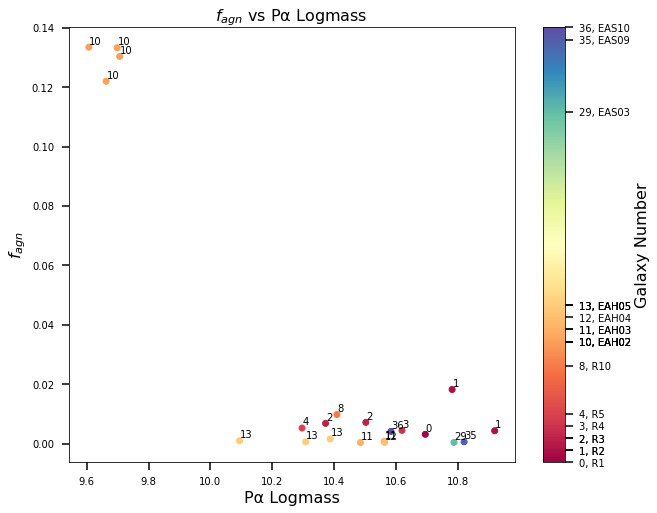

In [146]:
# Scatter_cmap = sns.color_palette("flare", num_runs)
# sns.set_palette(Scatter_cmap)
fig = figure(figsize=(10,8))
logmass = [lmass[0] for lmass in theta_bestfit]
fagn = [f_agn[14] for f_agn in theta_bestfit]
scatter(logmass, fagn, c=G_numbers, cmap='Spectral')

cbar = colorbar(ticks = G_numbers)
cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
cbar.set_label(label='Galaxy Number', size=16)

xlabel('Pα Logmass', size=16)
ylabel('$f_{agn}$', size= 16)
title('$f_{agn}$ vs Pα Logmass', size=16)
offset = .001

for i, txt in enumerate(G_numbers):
    annotate(txt, (logmass[i] + offset, fagn[i] + offset))

21 21


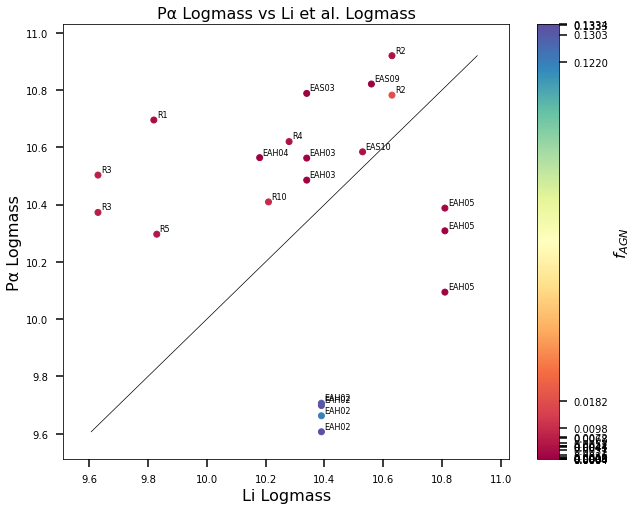

In [147]:
print(len(logmass), len(Gal_logmass))

logmass_min = min(logmass + Gal_logmass)
logmass_max = max(logmass + Gal_logmass)


logmass_line_lin = np.linspace(logmass_min, logmass_max, num=100)


fig = figure(figsize=(10,8))

# ax = fig.add_subplot(111)

scatter(Gal_logmass, logmass, c=fagn, cmap='Spectral')
# scatter(Gal_logmass, logmass, c=G_numbers, cmap='Spectral')

plot(logmass_line_lin, logmass_line_lin, 'k')

xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

title('Pα Logmass vs Li et al. Logmass', size=16)

cbar = colorbar(ticks = fagn)
# cbar = colorbar(ticks = G_numbers)

# cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
# cbar.set_label(label='Galaxy Number', size=16)
cbar.set_label(label='$f_{AGN}$', size=16)

ylabel('Pα Logmass', size=16)
xlabel('Li Logmass', size= 16)

offset = .01

for i, txt in enumerate(G_numbers):
    # print(i)
    annotate(Gal_desig[i], (Gal_logmass[i] + offset, logmass[i] + offset), size = 8)        #str(txt) + ','+ 


# https://github.com/bd-j/prospector/issues/151  <-- Mass is too large

In [148]:
# G0 - G8: R1 - R10:  https://academic.oup.com/mnras/article/448/1/258/1748852 
# G9- G25: EAH01 - EAH17: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# G27 - G431: EAS01 - EAS15: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# No data for G26 (EAH18) and G42 - G57 (F34-37, A1-12)
SDSS_Logmass_R = [9.8, 10.7, 9.6, 10.4, 9.9, 10.4, 10.2, 10.3, 10.2]
SDSS_Logmass_EAH = [10.45, 9.96, 10.34, 10.18, 10.00, 10.53, 10.65, 10.41, 10.21, 10.24, 10.61, 10.55, 11.00, 10.04, 10.40, 10.74, 10.05]
SDSS_Logmass_EAH18 = [np.inf]
SDSS_Logmass_EAS = [10.24, 10.08, 10.86, 9.99, 10.57, 10.14, 10.54, 10.67, 10.56, 10.53, 10.74, 10.01, 10.95, 11.31, 10.83]

num_empty = 58 - (len(SDSS_Logmass_R) + len(SDSS_Logmass_EAH) + len(SDSS_Logmass_EAS) + len(SDSS_Logmass_EAH18))
SDSS_Logmass_F_A = np.inf * np.ones(num_empty)

SDSS_Logmass = SDSS_Logmass_R + SDSS_Logmass_EAH + SDSS_Logmass_EAH18 + SDSS_Logmass_EAS + SDSS_Logmass_F_A.tolist()

In [149]:
SDSS_Logmass = np.array(SDSS_Logmass)
Logmass_mask = np.isfinite(SDSS_Logmass)

21 21 21


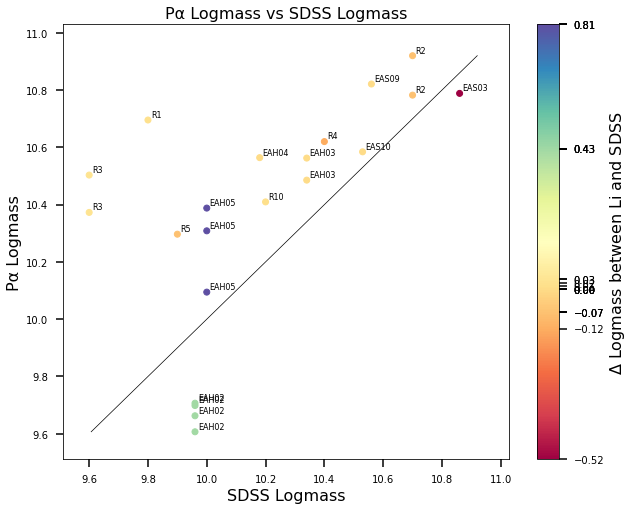

In [150]:
counter = 0
sorted_SDSS_logmass_4SDSS = []
sorted_Pa_logmass_4SDSS = []
sorted_Li_logmass_4SDSS = []
sorted_G_numbers_4SDSS = []
for i in G_numbers:
    if Logmass_mask[i] == True:
        sorted_G_numbers_4SDSS.append(i)
        sorted_SDSS_logmass_4SDSS.append(SDSS_Logmass[i])
        sorted_Pa_logmass_4SDSS.append(logmass[counter])
        sorted_Li_logmass_4SDSS.append(Gal_logmass[counter])
        # scatter(logmass[counter], All_SDSS_Logmass[i])
    counter += 1

sorted_SDSS_logmass_4SDSS = np.array(sorted_SDSS_logmass_4SDSS)
sorted_Li_logmass_4SDSS = np.array(sorted_Li_logmass_4SDSS)
sorted_Pa_logmass_4SDSS = np.array(sorted_Pa_logmass_4SDSS)
sorted_G_numbers_4SDSS = np.array(sorted_G_numbers_4SDSS)

print(len(sorted_Pa_logmass_4SDSS), len(sorted_SDSS_logmass_4SDSS), len(sorted_Li_logmass_4SDSS))



fig = figure(figsize=(10,8))

xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

title('Pα Logmass vs SDSS Logmass', size=16)
ylabel('Pα Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(logmass_line_lin, logmass_line_lin, 'k')
scatter(sorted_SDSS_logmass_4SDSS, logmass, c=(sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS), cmap='Spectral')

cbar = colorbar(ticks = (sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(sorted_G_numbers_4SDSS):
    annotate(Gal_desig[i], (sorted_SDSS_logmass_4SDSS[i] + offset, logmass[i] + offset), size = 8)        #str(txt) + ','+ 

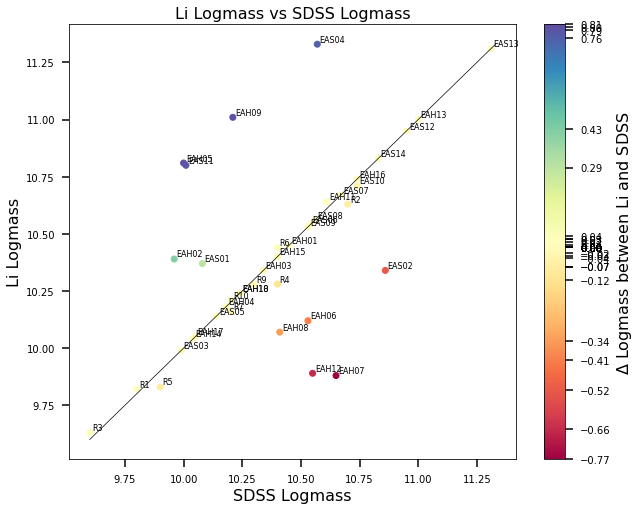

In [151]:
All_Li_logmass = []
SDSS_G_numbers = []
All_G_desig = []

for i in range(0, 58):
    All_Li_logmass.append(AGN_data[i][50])
    SDSS_G_numbers.append(i)
    All_G_desig.append(AGN_data[i][1])

All_Li_logmass = np.array(All_Li_logmass)
SDSS_G_numbers = np.array(SDSS_G_numbers)

All_SDSS_Logmass = SDSS_Logmass[Logmass_mask]
All_Li_logmass = All_Li_logmass[Logmass_mask]
SDSS_G_numbers = SDSS_G_numbers[Logmass_mask]



SDSS_logmass_min = min(min(All_SDSS_Logmass), min(All_Li_logmass))
SDSS_logmass_max = max(max(All_SDSS_Logmass), max(All_Li_logmass))

SDSS_logmass_line_lin = np.linspace(SDSS_logmass_min, SDSS_logmass_max, num=100)


fig = figure(figsize=(10,8))

# xlim(SDSS_logmass_min * 0.99, logmass_max * 1.01)
# ylim(SDSS_logmass_min * 0.99, logmass_max * 1.01)

title('Li Logmass vs SDSS Logmass', size=16)
ylabel('Li Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(SDSS_logmass_line_lin, SDSS_logmass_line_lin, 'k')
scatter(All_SDSS_Logmass, All_Li_logmass, c=(All_Li_logmass - All_SDSS_Logmass), cmap='Spectral')

cbar = colorbar(ticks = (All_Li_logmass - All_SDSS_Logmass))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(SDSS_G_numbers):
    annotate(All_G_desig[i], (All_SDSS_Logmass[i] + offset, All_Li_logmass[i] + offset), size = 8)        #str(txt) + ','+ 